In [ ]:
import numpy as np
import tensorflow as tf
from utils_functions import *
from plan import *
import random
from utils import *
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, InputLayer, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils  import plot_model
#from tensorflow.keras.utils  import Sequence
from sklearn.model_selection import train_test_split
import datetime, os
import pandas as pd
import optuna


In [2]:
# controllo di star effettivamente usando la GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print("nome gpu: ",tf.test.gpu_device_name())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
nome gpu:  /device:GPU:0


## Preparazione dati

Creazione dataset

In [ ]:
dizionario_stati = load_file("./dizionario_stati")
piani_caricati = load_file("./plans")

# Processo creazione dateset a sequenze

Sample: sequenza da 5 vettori, 4 in input, 1 (quello centrale) da ricostruire in output

In [3]:
#Metodi usati per ri-trasformare tutti gli array/liste in np array con np.int8
def convert_x_np(data):
    new_data=[]
    for seq in data:
        new_seq=[]
        for array in seq:
            np_a=np.array(array,dtype=np.int8)
            new_seq.append(np_a)
        np_seq=np.array(new_seq)
        new_data.append(np_seq)
    np_new_data=np.array(new_data)
    return np_new_data  

def convert_y_np(data):
    new_data=[]
    for array in data:
        np_a=np.array(array,dtype=np.int8)
        new_data.append(np_a) 
               
    np_new_data=np.array(new_data)
    print("Completato")
    return np_new_data  


In [19]:
dataset = costruisci_vettore_per_piano(dizionario_stati,piani_caricati)
dataset_5x340 = dataset_augmentation(dataset)

np.random.shuffle(dataset_5x340)
df = pd.DataFrame(dataset_5x340.tolist(), columns=['s0', 's1','s2','s3','s4'])
X=df[["s0","s1","s3","s4"]]
Y=df["s2"]
#Split
x_tmp, x_test, y_tmp, y_test = train_test_split(X,Y,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x_tmp,y_tmp,test_size = 0.25,train_size =0.75)

x_train=x_train.to_numpy(dtype=object)
y_train=y_train.to_numpy(dtype=object)

x_val=x_val.to_numpy(dtype=object)
y_val=y_val.to_numpy(dtype=object)

x_test=x_test.to_numpy(dtype=object)
y_test=y_test.to_numpy(dtype=object)

np_x_train=convert_x_np(x_train)
np_y_train=convert_y_np(y_train)

np_x_val=convert_x_np(x_val)
np_x_test=convert_x_np(x_test)

np_y_val=convert_y_np(y_val)
np_y_test=convert_y_np(y_test)

save_file(np_x_train, "./Dataset/", "set_training_x")
save_file(np_x_val, "./Dataset/", "set_validation_x")
save_file(np_x_test, "./Dataset/", "set_test_x")
    
save_file(np_y_train, "./Dataset/", "set_training_y")
save_file(np_y_val, "./Dataset/", "set_validation_y")
save_file(np_y_test, "./Dataset/", "set_test_y")

# Modello

Caricamento dataset 5 seq

In [ ]:
train_x=load_file("./Dataset/set_training_x")
train_y=load_file("./Dataset/set_training_y")
val_x=load_file("./Dataset/set_validation_x")
val_y=load_file("./Dataset/set_validation_y")
test_x=load_file("./Dataset/set_test_x")
test_y=load_file("./Dataset/set_test_y")

Caricamento dataset per modello 7 seq

In [ ]:
train_x=load_file("./Dataset/set_training7_x")
train_y=load_file("./Dataset/set_training7_y")
val_x=load_file("./Dataset/set_validation7_x")
val_y=load_file("./Dataset/set_validation7_y")
test_x=load_file("./Dataset/set_test7_x")
test_y=load_file("./Dataset/set_test7_y")

In [ ]:
logdir = os.path.join("./TestLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True, write_images=True)

]

#PARAM:
param={
"OUTPUT_SIZE": train_x.shape[2],
"HIDDEN_SIZE" : 1020,
"HIDDEN_SIZE2" : None,
"HIDDEN_SIZE3" : None,
"CODE_SIZE" : 510,
"KERNEL_INIZIALIZER":"he_uniform",
"KERNEL_REGULIZER":tf.keras.regularizers.L1(l1=3e-9),
'BIAS_REGULARIZER': None,
"ACTIVATION":"relu",
"OPTIMIZER":tf.keras.optimizers.Nadam(learning_rate=0.008,beta_1=0.95,beta_2=0.999),
"EPOCHS":400,
"BATCH_SIZE":500,
}

autoencoderV2=tf.keras.models.Sequential()
autoencoderV2.add(InputLayer(input_shape=(train_x.shape[1],train_x.shape[2])))

autoencoderV2.add(Flatten())
autoencoderV2.add(tf.keras.layers.BatchNormalization())
autoencoderV2.add( Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
autoencoderV2.add(Dropout(0.05))
autoencoderV2.add(tf.keras.layers.BatchNormalization())
#autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
#autoencoderV2.add(Dropout(0.05))
#autoencoderV2.add(tf.keras.layers.BatchNormalization())
#autoencoderV2.add( Dense(param["HIDDEN_SIZE3"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
#autoencoderV2.add(tf.keras.layers.BatchNormalization())

autoencoderV2.add(Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"],name="embedding"))
#autoencoderV2.add(Dropout(0.2))
autoencoderV2.add(tf.keras.layers.BatchNormalization())
#autoencoderV2.add( Dense(param["HIDDEN_SIZE3"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
#autoencoderV2.add(Dropout(0.2))
#autoencoderV2.add(tf.keras.layers.BatchNormalization())
#autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
#autoencoderV2.add(Dropout(0.2))
#autoencoderV2.add(tf.keras.layers.BatchNormalization())
autoencoderV2.add(Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
autoencoderV2.add(Dropout(0.3))
autoencoderV2.add(tf.keras.layers.BatchNormalization())
autoencoderV2.add( Dense(param["OUTPUT_SIZE"], activation='sigmoid',kernel_initializer=tf.keras.initializers.GlorotUniform()))

autoencoderV2.compile(optimizer=param["OPTIMIZER"], loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])
history=autoencoderV2.fit(x=train_x,y=train_y, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(val_x,val_y), 
                        callbacks=my_callbacks)

In [ ]:
autoencoderV2.summary()

## Optuna

In [ ]:
def objective(trial):
   
    l_rate=trial.suggest_float("learning rate", 1e-6, 2e-3, log=True)
    reg=trial.suggest_float("reg param", 1e-9, 1e-3, log=True)
    dropout_iniziale=trial.suggest_float("dropout iniziale", 0.05, 0.3,step=0.05, )
    dropout_finale=trial.suggest_float("dropout finale", 0.05, 0.3,step=0.05, )
    #dropouts_interni=trial.suggest_float("dropout interni", 0, 0.2,step=0.05, )
    param={
            "OUTPUT_SIZE":train_x.shape[2],
            "HIDDEN_SIZE" : 1020,
            "HIDDEN_SIZE2" : 510,
            "HIDDEN_SIZE3" : 255,
            "CODE_SIZE" : 200,        
            "KERNEL_INIZIALIZER":"he_uniform",
            "KERNEL_REGULIZER":tf.keras.regularizers.L2(l2=reg) ,
            'BIAS_REGULARIZER': None,
            "ACTIVATION":"relu",
            "OPTIMIZER":tf.keras.optimizers.Adam(learning_rate=l_rate),
            "EPOCHS":500,
            "BATCH_SIZE":1000,
            }
          
    autoencoderV2=tf.keras.models.Sequential()

    autoencoderV2.add(InputLayer(input_shape=(train_x.shape[1],train_x.shape[2])))
    autoencoderV2.add(Flatten())
    autoencoderV2.add(Dropout(dropout_iniziale))
    autoencoderV2.add(tf.keras.layers.BatchNormalization())
    autoencoderV2.add( Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
    
    autoencoderV2.add(tf.keras.layers.BatchNormalization())
    autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
    #autoencoderV2.add(Dropout(dropouts_interni))
    autoencoderV2.add(tf.keras.layers.BatchNormalization())
    autoencoderV2.add( Dense(param["HIDDEN_SIZE3"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
    #autoencoderV2.add(Dropout(0.1))
    autoencoderV2.add(tf.keras.layers.BatchNormalization())

    autoencoderV2.add(Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"],name="embedding"))
    autoencoderV2.add(tf.keras.layers.BatchNormalization())
    autoencoderV2.add( Dense(param["HIDDEN_SIZE3"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
    autoencoderV2.add(Dropout(dropout_finale))
    autoencoderV2.add(tf.keras.layers.BatchNormalization())
   
    autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
    autoencoderV2.add(Dropout(dropout_finale))
    autoencoderV2.add(tf.keras.layers.BatchNormalization())
    #autoencoderV2.add(Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
    #autoencoderV2.add(tf.keras.layers.BatchNormalization())
    autoencoderV2.add( Dense(param["OUTPUT_SIZE"], activation='sigmoid',kernel_initializer=tf.keras.initializers.GlorotUniform()))


    my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=15,restore_best_weights=True)]

    autoencoderV2.compile(optimizer=param["OPTIMIZER"], loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])
    history=autoencoderV2.fit(x=train_x,y=train_y, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(val_x,val_y), 
                            callbacks=my_callbacks)
    optuna_dir= os.path.join("./optunaLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    optuna_dir=os.path.join(optuna_dir, str(trial.number))
    autoencoderV2.save(optuna_dir)

    return history.history["loss"][-1]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, timeout=None, gc_after_trial=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


    

## Test

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss")
plt.show()
    
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='validation')
plt.legend()
plt.title("Precision")
plt.show()

plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.legend()
plt.title("Recall")
plt.show()

1046/1046 [==============================] - 3s 3ms/step
Numero di vettori decodificati correttamente: 21579 su 33459 totali 
Rapporto: 64.494% 
Media num di errori per array: 0.788



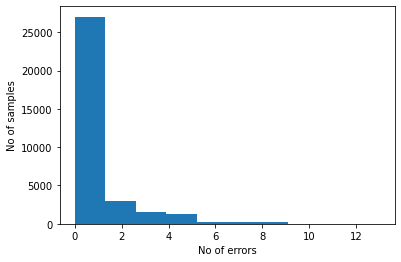

In [68]:
y_test_predict= autoencoderV2.predict(test_x) 
arr=results_info(test_y, y_test_predict,logdir)


In [ ]:

dir_model= os.path.join(logdir,"myModel")
autoencoderV2.save(dir_model)

In [ ]:
#CARICA AUTOENCODER SALVATO

PATH_TO_LOAD=""
autoencoderV2 = tf.keras.models.load_model(PATH_TO_LOAD)
autoencoderV2.summary()

# Dataset con 7 seq 

Creazione dataset con sample da 7 sequenze, 6 in input 1 in output

In [ ]:
dizionario_stati = load_file("./dizionario_stati")
piani_caricati = load_file("./plans")

dataset = costruisci_vettore_per_piano(dizionario_stati,piani_caricati)
print("Vettori per piani costruiti")

dataset_7x340 = dataset_augmentation(dataset,7)
print("Vettori di dim. 7 costruiti")

np.random.shuffle(dataset_7x340)

df = pd.DataFrame(dataset_7x340.tolist(), columns=['v0','v1','v2','v3','v4','v5','v6'])

X=df[["v0","v1","v2","v4","v5","v6"]]
Y=df["v3"]

print("Df X e Y estratti con successo, v3 usato come output da ricostruire")
#split
x_tmp, x_test, y_tmp, y_test = train_test_split(X,Y,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x_tmp,y_tmp,test_size = 0.25,train_size =0.75)

x_train=x_train.to_numpy(dtype=object)
y_train=y_train.to_numpy(dtype=object)

x_val=x_val.to_numpy(dtype=object)
y_val=y_val.to_numpy(dtype=object)

x_test=x_test.to_numpy(dtype=object)
y_test=y_test.to_numpy(dtype=object)
print("Split di train test e val completato")

np_x_train=convert_x_np(x_train)
np_y_train=convert_y_np(y_train)

np_x_val=convert_x_np(x_val)
np_x_test=convert_x_np(x_test)

np_y_val=convert_y_np(y_val)
np_y_test=convert_y_np(y_test)
print("Conversione degli split in np completata \n Inizio salvataggio")

save_file(np_x_train, "./Dataset/", "set_training7_x")
save_file(np_x_val, "./Dataset/", "set_validation7_x")
save_file(np_x_test, "./Dataset/", "set_test7_x")
    
save_file(np_y_train, "./Dataset/", "set_training7_y")
save_file(np_y_val, "./Dataset/", "set_validation7_y")
save_file(np_y_test, "./Dataset/", "set_test7_y")
